# Text Analysis

In [1]:
import nltk
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords 
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import collections as clt
import spacy

In [2]:
sp = spacy.load('en_core_web_sm')
df = pd.read_csv('reviews_full_v7.csv')
df.head()

,User,Date,Year,Month,Release,Band,Score,Link,Album_link,Review_title,Genre,Text,Sentiment,Band_Genre,Combined_Genre
0,SpookyApparition,July 11 2002,2002,7,Chaosphere,Meshuggah,82,https://www.metal-archives.com/reviews/Meshugg...,https://www.metal-archives.com/albums/Meshugga...,Technical metal at it's finest.,technical thrash metal|math metal|progressive ...,I originally bought Chaosphere in late 2000......,0.9728,groove metal|thrash metal,technical thrash metal|math metal|progressive ...
1,SpookyApparition,July 14 2002,2002,7,Necroticism_-_Descanting_the_Insalubrious,Carcass,88,https://www.metal-archives.com/reviews/Carcass...,https://www.metal-archives.com/albums/Carcass/...,Carcass at their finest.,grindcore|melodic death metal,A midpoint between Carcass' early grind albums...,0.8479,grindcore|death metal,grindcore|melodic death metal
2,MarkRyan,July 15 2002,2002,7,Angels_Fall_First,Nightwish,90,https://www.metal-archives.com/reviews/Nightwi...,https://www.metal-archives.com/albums/Nightwis...,On par with their other stuff...,symphonic power metal,"I'm not hard-core into metal at all, really, b...",0.9951,symphonic metal|power metal,symphonic power metal
3,Fear,July 16 2002,2002,7,Dark_Genesis,Iced_Earth,87,https://www.metal-archives.com/reviews/Iced_Ea...,https://www.metal-archives.com/albums/Iced_Ear...,Brilliance in Repackaging,heavy metal|us power metal,"This is not a new album, but in fact, five alb...",0.9976,thrash metal|power metal,heavy metal|us power metal
4,Esoteric,July 16 2002,2002,7,A_Night_at_the_Opera,Blind_Guardian,70,https://www.metal-archives.com/reviews/Blind_G...,https://www.metal-archives.com/albums/Blind_Gu...,Somewhat Disappointing,power metal,I've been trying for months to come up with an...,0.5494,speed metal|power metal,power metal


In [3]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [4]:
tokenizer = nltk.RegexpTokenizer(r"\w+") # removes punctuation and special characters

### Based on https://doi.org/10.1155/2013/394758
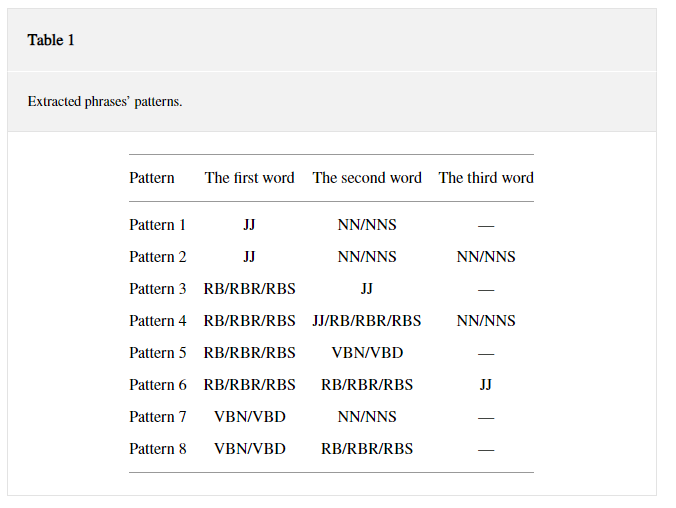

In [5]:
def isNoun(tag):
    return tag == 'NN' or tag == 'NNS'
    #return tag[:2] == 'NN'

def isAdverb(tag):
    return tag == 'RB' or tag == 'RBR' or tag == 'RBS'
    #return tag[:2] == 'RB'


def isVerb(tag):
    return tag == 'VBN' or tag == 'VBD'
    #return tag[:2] == 'VB'


def extract_features(sent):
    sent = list(sent)
    sent += [('NULL','NULL'), ('NULL','NULL')]
    all_features = []
    for i in range(len(sent)-2):
        word1, tag1 = sent[i]
        word2, tag2 = sent[i+1]
        word3, tag3 = sent[i+2]
        word1 = word1.lower()
        word2 = word2.lower()
        word3 = word3.lower()
        if tag1 == 'JJ':
            if isNoun(tag2):
                if isNoun(tag3):
                    all_features.append((word1, word2, word3)) #pattern 2
                else:
                    all_features.append((word1, word2)) #pattern 1
                    
        elif isAdverb(tag1):
            if tag2 == 'JJ':
                if isNoun(tag3):
                    all_features.append((word1, word2, word3)) #pattern 4
                else:
                    all_features.append((word1, word2)) #pattern 3
            elif isAdverb(tag2):
                if isNoun(tag3):
                    all_features.append((word1, word2, word3)) #pattern 4
                elif tag3 == 'JJ':
                    all_features.append((word1, word2, word3)) #pattern 6
            elif isVerb(tag2):
                all_features.append((word1, word2)) #pattern 5
        
        elif isVerb(tag1):
            if isNoun(tag2):
                all_features.append((word1, word2)) #pattern 7
            elif isAdverb(tag2):
                all_features.append((word1, word2)) #pattern 8
                
                
                
    return all_features

In [6]:
t1 = time.time()
all_features = {}

stop_words = set(sp.Defaults.stop_words)
#stop_words = set(stopwords.words('english')) 

key_phrases = []

for i,row in list(df.iterrows()):
    if i%5000 == 0:
        print(i,time.time()-t1)
    text = row['Text']
    sents = sent_tokenize(text)
    feature_list = []
    for sent in sents:
        tagged_sent = pos_tag([word for word in word_tokenize(sent) if word.isalnum() and len(word) > 2 and word not in stop_words])
        #print(tagged_sent)
        for phrase in extract_features(tagged_sent):
            feature = ' '.join(phrase)
            feature_list.append(feature)
            if feature in all_features:
                all_features[feature] += 1
            else:
                all_features[feature] = 1
    if len(feature_list) != 0:
        key_phrases.append('|'.join(feature_list))
    else:
        key_phrases.append(np.nan)

df['Key Features'] = key_phrases
df.to_csv('reviews_full_v8.csv',index = False)
#key_phrases

0 9.703087329864502
5000 149.6043655872345
10000 297.44385862350464
15000 443.7290062904358
20000 606.6978659629822
25000 762.838737487793
30000 924.4966082572937
35000 1084.01540017128
40000 1265.8957343101501
45000 1439.1029891967773
50000 1611.3196318149567
55000 1811.3820037841797
60000 1975.952805519104
65000 2157.457804918289
70000 2345.417656183243
75000 2515.0122604370117
80000 2682.585068464279
85000 2889.8635540008545
90000 3070.8939225673676


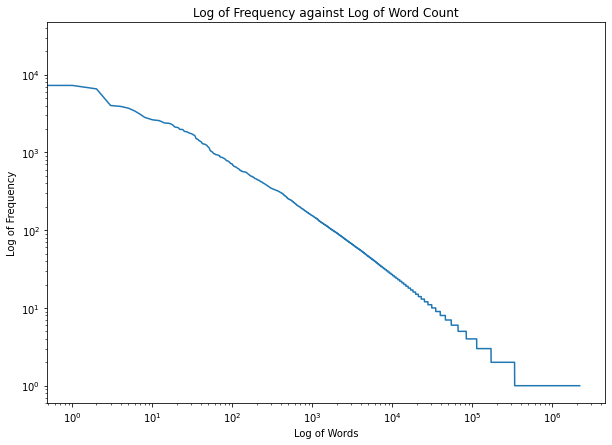

In [7]:
plt.title('Log of Frequency against Log of Word Count')
plt.ylabel('Log of Frequency')
plt.xlabel('Log of Words')
plt.loglog(sorted([all_features[key] for key in all_features],reverse = True))
plt.show()

In [8]:
mp = {k: v for k, v in sorted(all_features.items(), key=lambda item: item[1], reverse = True)}
print(len(mp))

2189617


In [9]:
phrases = pd.DataFrame()
phrases['Phrase'] = mp.keys()
phrases['Frequency'] = mp.values()
phrases.to_csv('opinionsv2.csv', index = False)

In [10]:
import pickle

pickle.dump(mp,open('opinionsv2.p','wb'))

In [11]:
phrases = pd.read_csv('opinions.csv')
phrases.head()

,Phrase,Frequency
0,black metal,30044
1,heavy metal,7625
2,clean vocals,6636
3,pretty much,4640
4,melodic death metal,3875


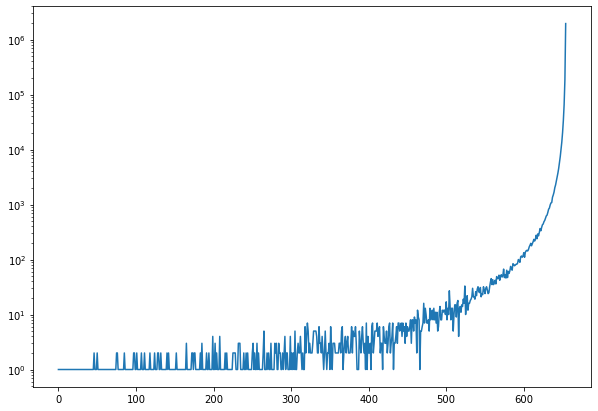

In [12]:
tmp = list(clt.Counter(phrases['Frequency']).values())

plt.semilogy(tmp)
#plt.loglog(phrases['Frequency'])
#plt.plot(tmp[-5:])
plt.show()

In [13]:
phrases.describe()

,Frequency
count,2.341710e+06
mean,2.002030e+00
std,2.601399e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,3.004400e+04


In [14]:
print(phrases.shape)
{k: v for k, v in sorted(clt.Counter(phrases['Frequency']).items(), key=lambda item: item[1], reverse = True)}

(2341710, 2)


{1: 1955955,
 2: 186160,
 3: 65810,
 4: 33807,
 5: 20442,
 6: 13690,
 7: 9942,
 8: 7439,
 9: 5774,
 10: 4575,
 11: 3756,
 12: 3150,
 13: 2683,
 14: 2278,
 15: 2030,
 16: 1688,
 17: 1495,
 18: 1358,
 19: 1085,
 20: 1070,
 21: 981,
 22: 862,
 23: 823,
 24: 721,
 25: 643,
 26: 621,
 27: 565,
 28: 515,
 29: 488,
 30: 443,
 31: 428,
 32: 383,
 34: 366,
 33: 334,
 35: 311,
 37: 292,
 39: 277,
 36: 270,
 38: 239,
 40: 235,
 42: 233,
 41: 217,
 43: 211,
 46: 197,
 44: 193,
 47: 182,
 45: 178,
 48: 170,
 49: 152,
 51: 147,
 52: 144,
 50: 143,
 53: 136,
 55: 133,
 58: 116,
 56: 116,
 59: 112,
 57: 110,
 54: 110,
 62: 100,
 61: 96,
 60: 89,
 63: 86,
 69: 84,
 65: 82,
 64: 82,
 68: 81,
 66: 79,
 67: 77,
 72: 75,
 71: 68,
 81: 67,
 77: 64,
 70: 64,
 73: 62,
 75: 61,
 74: 56,
 84: 53,
 79: 53,
 87: 52,
 82: 51,
 85: 50,
 90: 49,
 83: 48,
 80: 47,
 76: 47,
 78: 46,
 97: 45,
 89: 45,
 88: 45,
 95: 43,
 92: 42,
 86: 42,
 98: 39,
 93: 38,
 91: 36,
 96: 35,
 94: 35,
 131: 33,
 114: 32,
 107: 32,
 103: 32